# Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
working_directory = 'CS Masters/Deep Learning for Visual Recognition/Project Code/dl-superresolution-ipynb'
%cd /content/drive/MyDrive/$working_directory
#!git status

/content/drive/MyDrive/CS Masters/Deep Learning for Visual Recognition/Project Code/dl-superresolution-ipynb


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


## Git Management

In [ ]:
!git config --global user.email "e11909390@student.tuwien.ac.at"
!git config --global user.name "Lollobin"

In [ ]:
!git pull

In [90]:
!git status

^C


In [ ]:
!git commit -a -m "added connection for google colab"

In [ ]:
!git push

# Preparation

## Data Preprocessing

Generate patches for training and low res images for validation and testing.

### Patch Generation

In [ ]:
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import patchify
import numpy as np
import matplotlib.gridspec as gridspec
import glob as glob
import os
import cv2

SHOW_PATCHES = False
STRIDE = 14
SIZE = 32

def show_patches(patches):
    plt.figure(figsize=(patches.shape[0], patches.shape[1]))
    gs = gridspec.GridSpec(patches.shape[0], patches.shape[1])
    gs.update(wspace=0.01, hspace=0.02)
    counter = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            ax = plt.subplot(gs[counter])
            plt.imshow(patches[i, j, 0, :, :, :])
            plt.axis('off')
            counter += 1
    plt.show()

def create_patches(
    input_paths, out_hr_path, out_lr_path,
):
    os.makedirs(out_hr_path, exist_ok=True)
    os.makedirs(out_lr_path, exist_ok=True)
    all_paths = []
    for input_path in input_paths:
        all_paths.extend(glob.glob(f"{input_path}/*"))
    print(f"Creating patches for {len(all_paths)} images")
    for image_path in tqdm(all_paths, total=len(all_paths)):
        image = Image.open(image_path)
        image_name = image_path.split(os.path.sep)[-1].split('.')[0]
        w, h = image.size
        # Create patches of size (32, 32, 3)
        patches = patchify.patchify(np.array(image), (32, 32, 3), STRIDE)
        if SHOW_PATCHES:
            show_patches(patches)
        counter = 0
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                counter += 1
                patch = patches[i, j, 0, :, :, :]
                patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    f"{out_hr_path}/{image_name}_{counter}.png",
                    patch
                )
                # Convert to bicubic and save.
                h, w, _ = patch.shape
                low_res_img = cv2.resize(patch, (int(w*0.5), int(h*0.5)),
                                        interpolation=cv2.INTER_CUBIC)
                # Now upscale using BICUBIC.
                high_res_upscale = cv2.resize(low_res_img, (w, h),
                                            interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(
                    f"{out_lr_path}/{image_name}_{counter}.png",
                    high_res_upscale
                )

In [ ]:
create_patches(['input/T91'], 'input/t91_hr_patches', 'input/t91_lr_patches')

### Bicubic Scaling for Validation

In [ ]:
from PIL import Image
import glob as glob
import os

paths = ['input/Set14/original', 'input/Set5/original']
scale_factor = '2x' # options 2x, 3x, 4x
images = []

for path in paths:
    images.extend(glob.glob(f"{path}/*.png"))
print(len(images))
# Select scaling-factor and set up directories according to that.
if scale_factor == '2x':
    scale_factor = 0.5
    os.makedirs('input/test_bicubic_rgb_2x', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_2x'
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_hr = 'input/test_hr'
if scale_factor == '3x':
    scale_factor = 0.333
    os.makedirs('input/test_bicubic_rgb_3x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_3x'
    save_path_hr = 'input/test_hr'
if scale_factor == '4x':
    scale_factor = 0.25
    os.makedirs('input/test_bicubic_rgb_4x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_4x'
    save_path_hr = 'input/test_hr'
print(f"Scaling factor: {scale_factor}")
print(f"Low resolution images save path: {save_path_lr}")
for image in images:
    orig_img = Image.open(image)
    image_name = image.split(os.path.sep)[-1]
    w, h = orig_img.size[:]
    print(f"Original image dimensions: {w}, {h}")
    orig_img.save(f"{save_path_hr}/{image_name}")
    low_res_img = orig_img.resize((int(w*scale_factor), int(h*scale_factor)), Image.BICUBIC)
    # Upscale using BICUBIC.
    high_res_upscale = low_res_img.resize((w, h), Image.BICUBIC)
    high_res_upscale.save(f"{save_path_lr}/{image_name}")

## Utils

Define utility functions that are used later on.

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
plt.style.use('ggplot')
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    Note that the output and label pixels (when dealing with images) should
    be normalized as the `max_val` here is 1 and not 255.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

def save_plot(train_loss, val_loss, train_psnr, val_psnr):
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')
    plt.close()
    # PSNR plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig('outputs/psnr.png')
    plt.close()

def save_model_state(model):
    # save the model to disk
    print('Saving model...')
    torch.save(model.state_dict(), 'outputs/model.pth')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # Remove the last model checkpoint if present.
    torch.save({
                'epoch': epochs+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"outputs/model_ckpt.pth")

def save_validation_results(outputs, epoch, batch_iter):
    """
    Function to save the validation reconstructed images.
    """
    save_image(
        outputs,
        f"outputs/valid_results/val_sr_{epoch}_{batch_iter}.png"
    )

# Data Loading

In [36]:
import torch
import numpy as np
import glob as glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")
        self.all_label_paths = glob.glob(f"{label_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        image = Image.open(self.all_image_paths[index]).convert('RGB')
        label = Image.open(self.all_label_paths[index]).convert('RGB')
        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)
        image /= 255.
        label /= 255.
        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    train_image_paths, train_label_paths,
    valid_image_path, valid_label_paths
):
    dataset_train = SRCNNDataset(
        train_image_paths, train_label_paths
    )
    dataset_valid = SRCNNDataset(
        valid_image_path, valid_label_paths
    )
    return dataset_train, dataset_valid

# Prepare the data loaders
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=TEST_BATCH_SIZE,
        shuffle=False
    )
    return train_loader, valid_loader

In [37]:
import torch
import numpy as np
import glob as glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1

class ResizeToEven:
    def __call__(self, image):
        # Get current size
        width, height = image.size

        # If the width or height is odd, reduce by one pixel
        new_width = width if width % 2 == 0 else width - 1
        new_height = height if height % 2 == 0 else height - 1

        # Resize the image if needed
        if new_width != width or new_height != height:
            image = image.resize((new_width, new_height), Image.BICUBIC)

        return image

transform_image = transforms.Compose([
        ResizeToEven(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_label = transforms.Compose([
        ResizeToEven(),
        transforms.ToTensor(),
    ])

class ResNetSRCNNDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")
        self.all_label_paths = glob.glob(f"{label_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        image = Image.open(self.all_image_paths[index]).convert('RGB')
        label = Image.open(self.all_label_paths[index]).convert('RGB')

        image = transform_image(image)
        label = transform_label(label)

        return image, label

# Prepare the datasets.
def get_datasets(
    train_image_paths, train_label_paths,
    valid_image_path, valid_label_paths
):
    dataset_train = ResNetSRCNNDataset(
        train_image_paths, train_label_paths
    )
    dataset_valid = ResNetSRCNNDataset(
        valid_image_path, valid_label_paths
    )
    return dataset_train, dataset_valid

# Prepare the data loaders
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=TEST_BATCH_SIZE,
        shuffle=False
    )
    return train_loader, valid_loader



In [38]:
%matplotlib inline

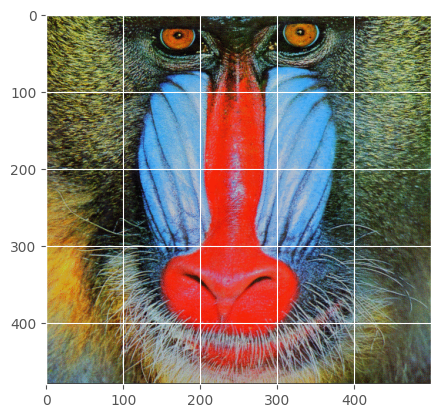

In [39]:
from torchvision import utils

def imshow(img):
    img = img.numpy().transpose((1,2,0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)

TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

#images = next(iter(train_loader))
images = next(iter(valid_loader))

#out = utils.make_grid(images)
imshow(images[1][0])

# Network Definition

## SRCNN

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=9, stride=(1, 1), padding=(2, 2)
        )
        self.conv2 = nn.Conv2d(
            64, 32, kernel_size=1, stride=(1, 1), padding=(2, 2)
        )
        self.conv3 = nn.Conv2d(
            32, 3, kernel_size=5, stride=(1, 1), padding=(2, 2)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

## ResNet SRCNN Combination

In [41]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class ResNetSRCNN(nn.Module):
    def __init__(self):
        super(ResNetSRCNN, self).__init__()

        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            resnet.layer1  # First residual block (without downsampling)
        )

        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False

        # SRCNN-inspired layers for feature extraction and reconstruction
        self.reconstruction = nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size=4,stride=2,padding=1), # Upscaling to keep input and output size the same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Keep the spatial size same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB channels
        )

        self.layer_activations = [] # Store layer activations here


    def forward(self, x):
        self.layer_activations = []
        # Feature extraction (ResNet initial layers)
        features = self.resnet_layers(x)

        # Reconstruction (SRCNN-inspired layers)

        for layer in features:
            x = self.reconstruction(layer)
            self.layer_activations.append(x)

        #x = self.reconstruction(features)

        return x

    # Return stored layer activations
    def activations(self):
        return self.layer_activations

In [82]:
# Create the model
resNetSRCNN = ResNetSRCNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNetSRCNN = resNetSRCNN.to(device)

# Example forward pass with a dummy input
dummy_input = torch.randn(1, 3, 18,18).to(device)
dummy_labels = torch.randint(low=1, high=3, size=(3,18)).to(device)

resnet_output = resNetSRCNN.resnet_layers(dummy_input)
output = resNetSRCNN(dummy_input)

# Output shape should match the input shape
print(f"Input shape: {dummy_input.shape}")
print(f"Labels shape: {dummy_labels.shape}")
print(f"Labels: {dummy_labels}")
print(f"ResNet output shape: {resnet_output.shape}")
print(f"Final output shape: {output.shape}")
print(f"activations: {resNetSRCNN.reconstruction}")
#print(resNetSRCNN)

Input shape: torch.Size([1, 3, 18, 18])
Labels shape: torch.Size([3, 18])
Labels: tensor([[1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1],
        [1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2],
        [1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1]],
       device='cuda:0')
ResNet output shape: torch.Size([1, 64, 9, 9])
Final output shape: torch.Size([3, 18, 18])
activations: Sequential(
  (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Visualize Dummy Data

In [83]:
# Calculate scores
scores = output  # predictions
labels = dummy_labels

print(scores.shape)
print(labels.shape)

torch.Size([3, 18, 18])
torch.Size([3, 18])


In [84]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.0741, device='cuda:0')


In [85]:
# Calculate the loss
import torch.nn.functional as F
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.8892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [86]:
# Calculate gradients
loss.backward()

In [87]:
def get_layer_data(model):
  gradients = []
  layer_names = []

  with torch.no_grad():
    for name, param in model.named_parameters():
      if param.requires_grad and "weight" in name:
          layer_names.append(name)
          gradients.append(param.grad)

  activations = model.activations()

  return layer_names, activations, gradients



layer_names, activations, gradients = get_layer_data(resNetSRCNN)
print('layer_names',layer_names)
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)
print('Activations type layer 1:',type(activations[0]))
print('Gradient list length:',len(gradients))
#print('Gradient shape layer 1:',gradients[0].shape)

layer_names ['reconstruction.0.weight', 'reconstruction.2.weight', 'reconstruction.4.weight', 'reconstruction.6.weight']
Activation list length: 1
Activations shape layer 1: torch.Size([3, 18, 18])
Activations type layer 1: <class 'torch.Tensor'>
Gradient list length: 4


In [88]:
def get_layer_stats(x,absolute=False):
  avg = []
  std = []
  for layer in range(len(x)):
    if absolute:
      avg.append(x[layer].abs().mean().detach().cpu().numpy())
    else:
      avg.append(x[layer].mean().detach().cpu().numpy())

    std.append(x[layer].std().detach().cpu().numpy())

  return avg, std

activation_mean, activation_std = get_layer_stats(activations)
gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

print('activation_mean',activation_mean)
print('activation_std',activation_std)
print('gradient_mean',gradient_mean)
print('gradient_std',gradient_std)

activation_mean [array(-0.00453058, dtype=float32)]
activation_std [array(0.04725373, dtype=float32)]
gradient_mean [array(0.00030022, dtype=float32), array(0.00030835, dtype=float32), array(0.00040483, dtype=float32), array(0.00130097, dtype=float32)]
gradient_std [array(0.00044553, dtype=float32), array(0.00043379, dtype=float32), array(0.00068108, dtype=float32), array(0.00209191, dtype=float32)]


Gradients:



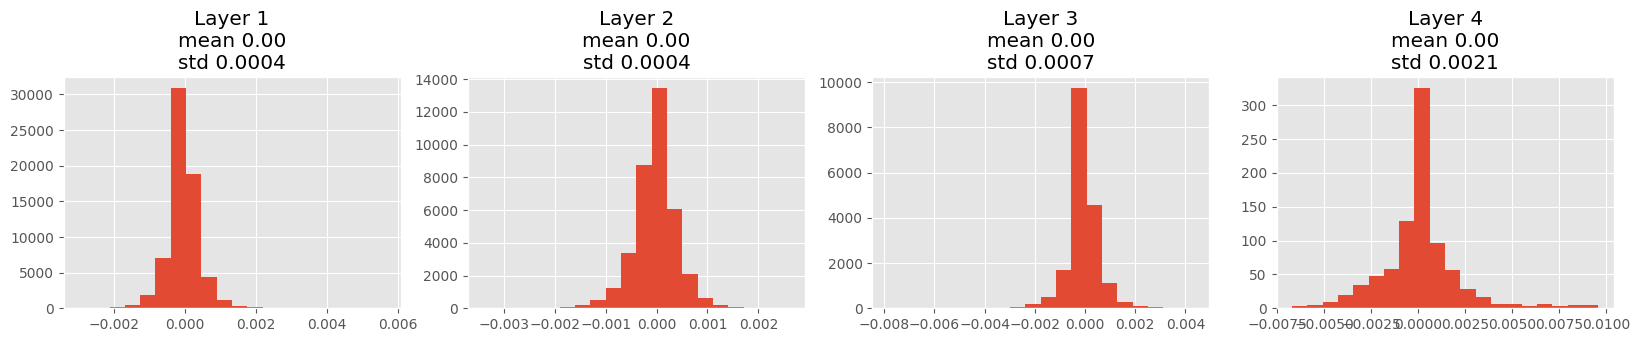

Activations:



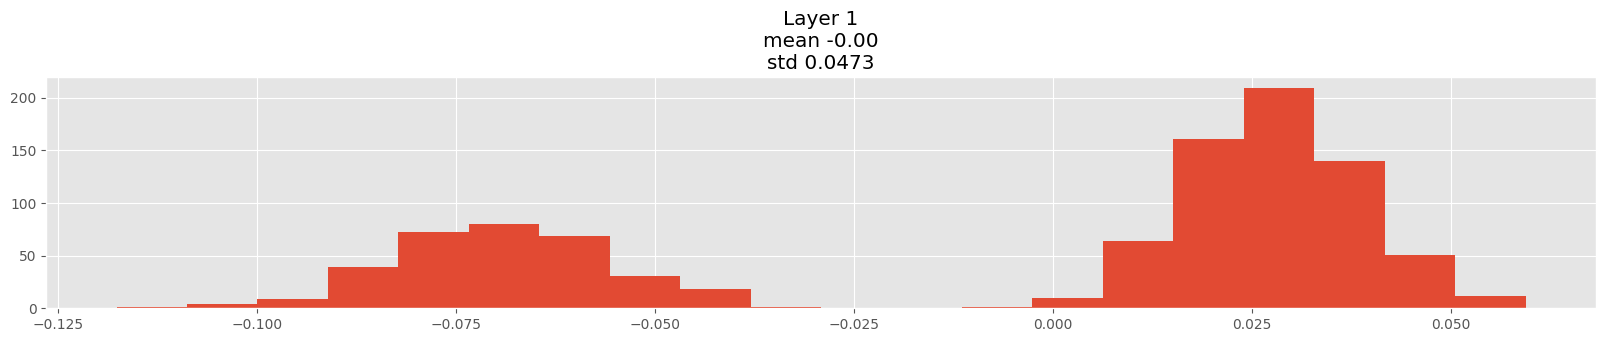

In [89]:
def plot_hist(hs,xrange=(-1,1),avg=None,sd=None):
  plt.figure(figsize=(20,3))
  for layer in range(len(hs)):
    plt.subplot(1,len(hs),layer+1)
    activations = hs[layer].detach().cpu().numpy().flatten()
    plt.hist(activations, bins=20, range=xrange)

    title = 'Layer ' + str(layer+1)
    if avg:
      title += '\n' + "mean {0:.2f}".format(avg[layer])
    if sd:
      title += '\n' + "std {0:.4f}".format(sd[layer])

    plt.title(title)

print('Gradients:\n')
plot_hist(gradients,xrange=None,avg=gradient_mean,sd=gradient_std)
plt.show()

print('Activations:\n')
plot_hist(activations,xrange=None,avg=activation_mean,sd=activation_std)
plt.show()

# Training

In [43]:
import torch
import time
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm

torch.cuda.is_available()

True

In [ ]:
# Learning parameters.
epochs = 100 # Number of epochs to train the SRCNN model for.
lr = 0.001 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = None # weights/checkpoint path to resume training

# Constants
TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

os.makedirs('outputs/valid_results', exist_ok=True)

# Initialize the model.
print('Computation device: ', device)
model = ResNetSRCNN().to(device)
if weights is not None:
    print('Loading weights to resume training...')
    checkpoint = torch.load(weights)
    model.load_state_dict(checkpoint['model_state_dict'])
print(model)

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)

# Loss function.
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)

        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)

        outputs_denorm = denormalize(outputs)

        loss = criterion(outputs_denorm, label)

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(label, outputs_denorm)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)

            outputs = model(image_data)
            outputs_denorm = denormalize(outputs)
            loss = criterion(outputs_denorm, label)

            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()

            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs_denorm)
            running_psnr += batch_psnr

            # For saving the batch samples for the validation results
            # every 500 epochs.
            if SAVE_VALIDATION_RESULTS and (epoch % 500) == 0:
                save_validation_results(outputs_denorm, epoch, bi)
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

    # Save model with all information every 100 epochs. Can be used
    # resuming training.
    if (epoch+1) % 100 == 0:
        save_model(epoch, model, optimizer, criterion)

    # Save the model state dictionary only every epoch. Small size,
    # can be used for inference.
    save_model_state(model)

    # Save the PSNR and loss plots every epoch.
    save_plot(train_loss, val_loss, train_psnr, val_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

# Testing

In [43]:
import torch

# Remember to define/run psnr in utils
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the model.
model = ResNetSRCNN().to(device)
model.load_state_dict(torch.load('outputs/model.pth'))
data_paths = [
    ['input/Set5/original', 'Set5'],
    ['input/Set14/original', 'Set14']
]
for data_path in data_paths:
    dataset_test = get_test_datasets(data_path[0])
    test_loader = get_test_dataloaders(dataset_test)
    _, test_psnr = validate(model, test_loader, device)
    print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

<ipython-input-43-c2b0243d0a9e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('outputs/model.pth'))
100%|██████████| 5/5 [00:05<00:00,  

Test PSNR on Set5: 12.765


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]

Test PSNR on Set14: 12.246


Test loading and upscaling a single image.

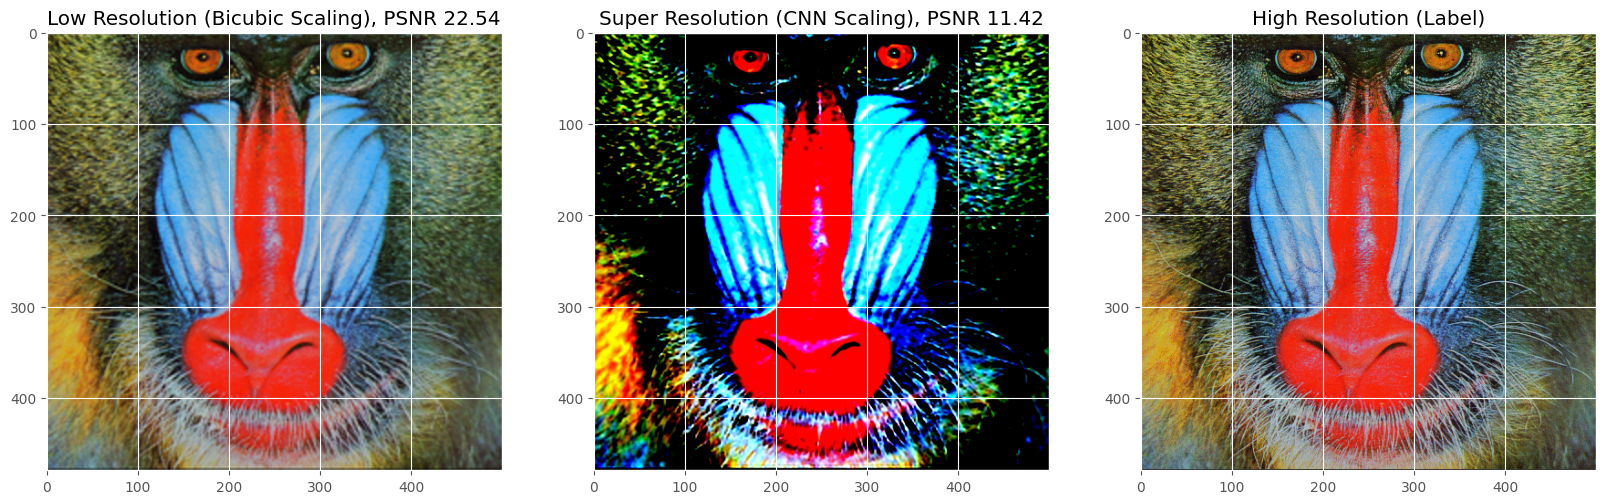

In [46]:
train_images = next(iter(train_loader))
valid_images = next(iter(valid_loader))

with torch.no_grad():
    lr_image = denormalize(valid_images[0]).to(device)
    hr_image = valid_images[1].to(device)
    sr_image = denormalize(model(valid_images[0].to(device)))

    lr_psnr = psnr(hr_image,lr_image)
    sr_psnr = psnr(sr_image,hr_image)

lr_image = lr_image.cpu()[0].numpy().transpose((1,2,0))
hr_image = hr_image.cpu()[0].numpy().transpose((1,2,0))
sr_image = sr_image.cpu()[0].numpy().transpose((1,2,0))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f"Low Resolution (Bicubic Scaling), PSNR {lr_psnr:.2f}")
plt.imshow(lr_image)
plt.subplot(1,3,2)
plt.title(f"Super Resolution (CNN Scaling), PSNR {sr_psnr:.2f}")
plt.imshow(sr_image)
plt.subplot(1,3,3)
plt.title("High Resolution (Label)")
plt.imshow(hr_image)
plt.show()

Test sets of images

In [1]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)

            outputs = denormalize(outputs)

            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


# The SRCNN dataset module.
class TestDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]

        # rescale if uneven
        new_w = w if w % 2 == 0 else w-1
        new_h = h if h % 2 == 0 else h-1
        if new_w != w or new_h != h:
            w = new_w
            h = new_h
            label = label.resize((w,h), Image.BICUBIC)

        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)


        image /= 255.
        label /= 255.

        # normalize lr image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean)/std

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_test_datasets(
    image_paths
):
    dataset_test = TestDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_test_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False
    )
    return test_loader

In [2]:
# Load the model.
model = ResNetSRCNN().to(device)
model.load_state_dict(torch.load('outputs/model.pth'))
data_paths = [
    ['input/Set5/original', 'Set5'],
    ['input/Set14/original', 'Set14']
]
for data_path in data_paths:
    dataset_test = get_test_datasets(data_path[0])
    test_loader = get_test_dataloaders(dataset_test)
    _, test_psnr = validate(model, test_loader, device)
    print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

NameError: name 'ResNetSRCNN' is not defined